<a href="https://www.kaggle.com/code/loopedward/guess-the-movie-genre?scriptVersionId=140342361" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data Ingestion

## The Whole Dataset

In [2]:
FILE_LOCATION = '/kaggle/input/movie-genre-prediction/train.csv'
df = pd.read_csv(FILE_LOCATION)
df

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action
...,...,...,...,...
53995,80325,Untitled Monkeyshine/Ugly Brother Project,Two loser pest control buddies find themselves...,scifi
53996,84712,The Great Swindle,A seductive woman gets involved in relationshi...,thriller
53997,69801,When Men Get Pregnant,"Duyen, a wedding dress staff, who decides to c...",romance
53998,7678,Suttu Pidikka Utharavu,The people of a crowded colony in Coimbatore c...,action


In [3]:
len(df)

54000

In [4]:
df['genre'].value_counts()

fantasy      5400
horror       5400
family       5400
scifi        5400
action       5400
crime        5400
adventure    5400
mystery      5400
romance      5400
thriller     5400
Name: genre, dtype: int64

<Axes: >

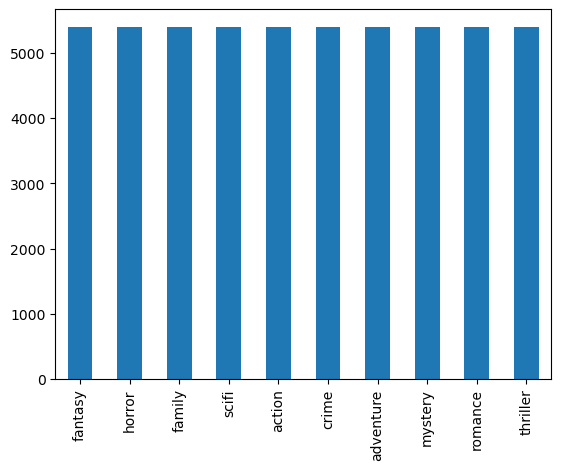

In [5]:
(df['genre'].value_counts()).plot(kind='bar')

## Allocate records for the test set

In [6]:
from sklearn.model_selection import train_test_split

(train_df, test_df) = train_test_split(df, test_size=0.1, 
                                       random_state=42, 
                                       stratify=df['genre'])
(train_df.shape, test_df.shape)

((48600, 4), (5400, 4))

In [7]:
test_df['genre'].value_counts()

romance      540
horror       540
action       540
scifi        540
family       540
mystery      540
crime        540
adventure    540
fantasy      540
thriller     540
Name: genre, dtype: int64

<Axes: >

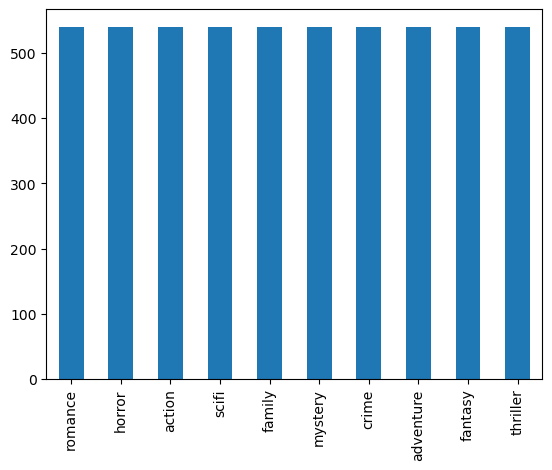

In [8]:
# Make sure test_df class labels follow original ones
(test_df['genre'].value_counts()).plot(kind='bar')

## Allocate records for validation set

In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.2, 
                                    random_state=42,
                                    stratify=train_df['genre'])

len(train_df), len(val_df)

(38880, 9720)

In [10]:
train_df['genre'].value_counts()

horror       3888
scifi        3888
family       3888
crime        3888
thriller     3888
romance      3888
action       3888
adventure    3888
fantasy      3888
mystery      3888
Name: genre, dtype: int64

<Axes: >

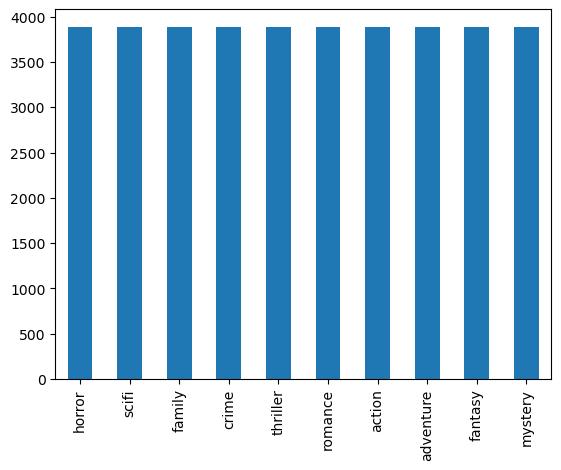

In [11]:
train_df['genre'].value_counts().plot(kind='bar')

In [12]:
val_df['genre'].value_counts()

romance      972
crime        972
scifi        972
fantasy      972
family       972
mystery      972
adventure    972
action       972
thriller     972
horror       972
Name: genre, dtype: int64

<Axes: >

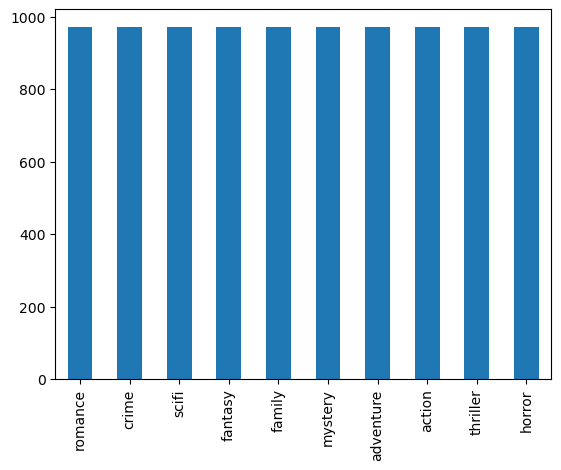

In [13]:
val_df['genre'].value_counts().plot(kind='bar')

# Data Analysis

## Class Labels

In [14]:
y_counts = train_df['genre'].value_counts()
y_counts

horror       3888
scifi        3888
family       3888
crime        3888
thriller     3888
romance      3888
action       3888
adventure    3888
fantasy      3888
mystery      3888
Name: genre, dtype: int64

## Movie Name Word Count 

In [15]:
movie_name_lengths = [len(name.split()) for name in train_df['movie_name']]
movie_name_lengths = pd.DataFrame(movie_name_lengths)

movie_name_lengths.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,38880.0,2.837912,1.676202,1.0,2.0,2.0,4.0,20.0


array([[<Axes: title={'center': '0'}>]], dtype=object)

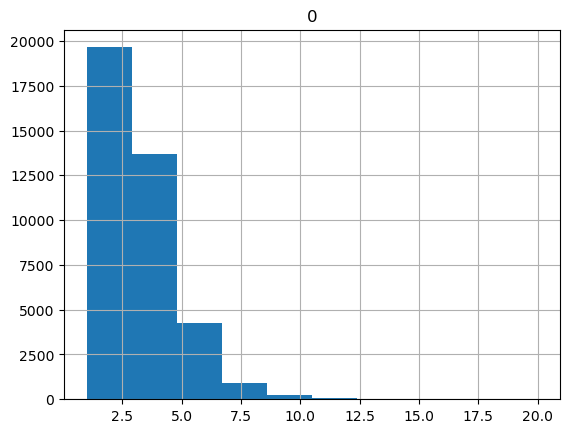

In [16]:
movie_name_lengths.hist()

In [17]:
np.percentile(movie_name_lengths, 99)

8.0

## Movie Synopsis Word Count

In [18]:
synopsis_lengths = [len(s.split()) for s in train_df['synopsis']]
synopsis_lengths = pd.DataFrame(synopsis_lengths)

synopsis_lengths.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,38880.0,26.233693,9.809758,1.0,19.0,26.0,34.0,70.0


array([[<Axes: title={'center': '0'}>]], dtype=object)

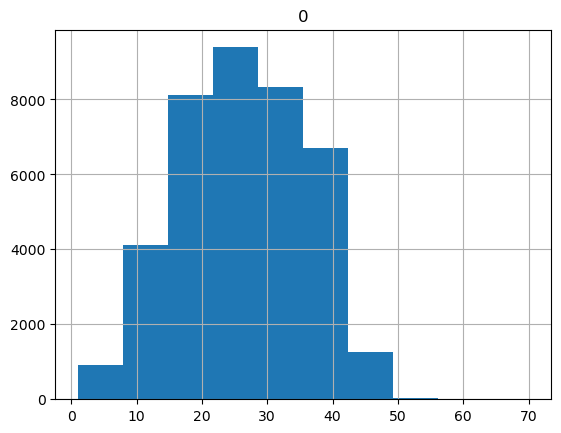

In [19]:
synopsis_lengths.hist()

In [20]:
np.percentile(synopsis_lengths, 99)

45.0

# Data Pre-processing

## Encoding the class labels

In [21]:
from sklearn.preprocessing import LabelEncoder

class_encoder = LabelEncoder()
class_encoder.fit(train_df['genre'])
CLASSES = class_encoder.classes_
CLASSES

array(['action', 'adventure', 'crime', 'family', 'fantasy', 'horror',
       'mystery', 'romance', 'scifi', 'thriller'], dtype=object)

In [22]:
class_encoder.transform(['action', 'crime', 'thriller'])

array([0, 2, 9])

## Preprocess the train and validationdatasets

In [23]:
from tensorflow.data import Dataset, AUTOTUNE

BATCH_SIZE = 128
def build_model_datasets(features, labels):
    y = class_encoder.transform(labels)
    dataset = Dataset.from_tensor_slices((features, y)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return dataset

train_dataset = build_model_datasets(train_df['synopsis'], train_df['genre'])
val_dataset = build_model_datasets(val_df['synopsis'], val_df['genre'])

train_dataset, val_dataset, len(train_dataset), len(val_dataset)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 304,
 76)

In [24]:
for i in train_dataset:
    print(i)
    break;

(<tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'A maniac cut and burn the body of the victims without a real reason. Annie (Frances Williams) the sister of one of the girls killed, wanna know more about this mistery and for her starts a nightmare.',
       b'A young undercover cop fights to control a constantly changing reality while trying to maintain her own grip on sanity when she joins the hunt for a brutal serial killer.',
       b'In the not too distant future, Earth is attacked by a foreign enemy. With help from an alien ally, mankind must rebuild on a new planet but one man assigned to the job has a personal agenda that could jeopardize the entire mission.',
       b"It's a journey of a man who was born handicapped without hands but he never lost confidence in himself and ends up an opened school on his mother name where all normal and abnormal kids can study together.",
       b'Val Barber, a private investigator, is hired by a wealthy widow to find her missing grandd

## The Vectorizer

In [25]:
from tensorflow.keras.layers import TextVectorization

SYNOPSIS_VOCAB_SIZE = 4096
SYNOPSIS_SEQ_LENGTH = 64

vectorizer = TextVectorization(max_tokens=SYNOPSIS_VOCAB_SIZE, output_sequence_length=SYNOPSIS_SEQ_LENGTH)
vectorizer.adapt(train_df['synopsis'])

In [26]:
vectorizer.get_vocabulary()[:5], vectorizer.get_vocabulary()[-5:]

(['', '[UNK]', 'a', 'the', 'to'],
 ['freespirited', 'fred', 'filipino', 'fed', 'fair'])

In [27]:
vectorizer(train_df['synopsis'][0])

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([   2,   23,    1,  298, 1806, 2083,    1,   70,   19,    8,  648,
       1105,    5,   90, 1947,   15,    2,  561, 2405,   50,  317,   32,
        327,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])>

# Modelling

## Baseline Model: Dense Layer

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D

EMBEDDING_LENGTH = 256
def build_model_0():
    return Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Embedding(SYNOPSIS_VOCAB_SIZE, EMBEDDING_LENGTH, input_length=SYNOPSIS_SEQ_LENGTH),
        GlobalAveragePooling1D(),
        Dense(256, activation='relu'),
        Dense(len(CLASSES), activation='softmax')
    ], name='model_0')

In [29]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

def compile_model(model):
    model.compile(
        loss=SparseCategoricalCrossentropy(),
        optimizer=Adam(),
        metrics=['accuracy']
    )

In [30]:
model_0 = build_model_0()
compile_model(model_0)
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 64)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 64, 256)           1048576   
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1,116,938
Trainable params: 1,116,938
Non-tra

In [31]:
model_0_history = model_0.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
304/304 [==============================] - 37s 104ms/step - loss: 2.1666 - accuracy: 0.2067 - val_loss: 1.9466 - val_accuracy: 0.3017
Epoch 2/5
304/304 [==============================] - 2s 7ms/step - loss: 1.8360 - accuracy: 0.3366 - val_loss: 1.8859 - val_accuracy: 0.3271
Epoch 3/5
304/304 [==============================] - 2s 7ms/step - loss: 1.7374 - accuracy: 0.3784 - val_loss: 1.8754 - val_accuracy: 0.3374
Epoch 4/5
304/304 [==============================] - 2s 7ms/step - loss: 1.6692 - accuracy: 0.4066 - val_loss: 1.8733 - val_accuracy: 0.3442
Epoch 5/5
304/304 [==============================] - 2s 6ms/step - loss: 1.6135 - accuracy: 0.4268 - val_loss: 1.8817 - val_accuracy: 0.3450


<Axes: >

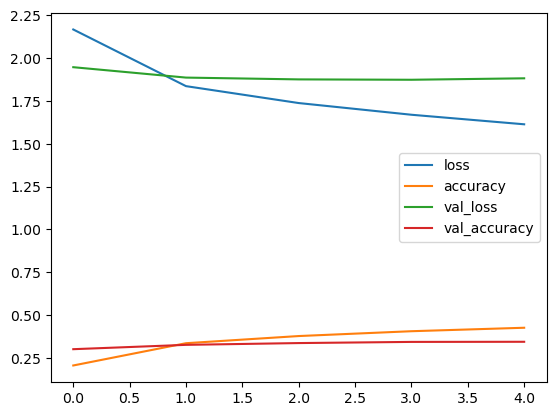

In [32]:
pd.DataFrame(model_0_history.history).plot()

# Evaluate the model using the test set

## Preprocess the test set

In [33]:
X_TEST = Dataset.from_tensor_slices(test_df['synopsis']).batch(BATCH_SIZE).prefetch(AUTOTUNE)
X_TEST

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [34]:
Y_TEST = class_encoder.transform(test_df['genre'])
batched_Y_TEST = Dataset.from_tensor_slices(Y_TEST).batch(BATCH_SIZE).prefetch(AUTOTUNE)
batched_Y_TEST

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

43/43 [==============================] - 0s 3ms/step


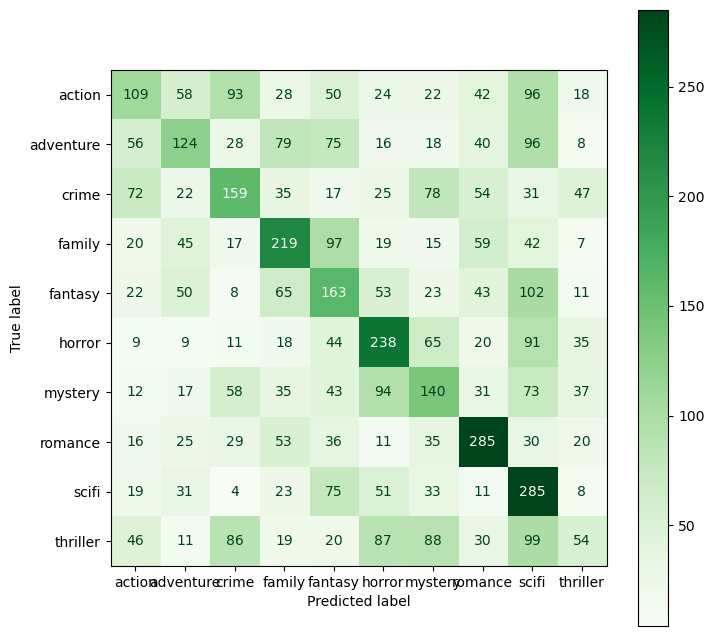

In [35]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

def model_predict(model):
    predictions = model.predict(X_TEST)
    predictions = np.argmax(predictions, axis=1)
    predictions = class_encoder.inverse_transform(predictions)    
    return predictions 

def plot_confusion_matrix(y_true, y_pred):
    display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                   cmap='Greens')
    fig = display.ax_.get_figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)

def evaluate_model(model):
    predictions = model_predict(model)
    macro_metrics = precision_recall_fscore_support(test_df['genre'], predictions, average="macro")
    weighted_metrics = precision_recall_fscore_support(test_df['genre'], predictions, labels=CLASSES)
    plot_confusion_matrix(test_df['genre'], predictions)
    return {
        'weighted_metrics': weighted_metrics, 
        'precision': macro_metrics[0],
        'recall': macro_metrics[1],
        'f1-score': macro_metrics[2],
        'predictions': predictions
    }
    
model_0_data = evaluate_model(model_0)

In [36]:
model_0_data

{'weighted_metrics': (array([0.28608924, 0.31632653, 0.32251521, 0.3815331 , 0.26290323,
         0.38511327, 0.27079304, 0.46341463, 0.3015873 , 0.22040816]),
  array([0.20185185, 0.22962963, 0.29444444, 0.40555556, 0.30185185,
         0.44074074, 0.25925926, 0.52777778, 0.52777778, 0.1       ]),
  array([0.23669924, 0.26609442, 0.30784124, 0.39317774, 0.28103448,
         0.41105354, 0.26490066, 0.49350649, 0.38383838, 0.13757962]),
  array([540, 540, 540, 540, 540, 540, 540, 540, 540, 540])),
 'precision': 0.3210683713648728,
 'recall': 0.3288888888888889,
 'f1-score': 0.31757258183250936,
 'predictions': array(['romance', 'horror', 'action', ..., 'fantasy', 'horror', 'action'],
       dtype=object)}

In [37]:
def report_model(data):
    print("====================== Metrics =======================")
    print(f"{'class':16s} |{'precision':>11}|{'recall':>11}|{'F1-score':>11}|")
    for i, label in enumerate(CLASSES):
        metrics = data['weighted_metrics']
        precision = metrics[0][i]
        recall = metrics[1][i]
        f1 = metrics[2][i]
        print(f"{label.upper():16s} |{precision:>11.6f}|{recall:>11.6f}|{f1:>11.6f}|")

    print("======================================================")
    print(f"{'GLOBAL':16s} |{data['precision']:>11.6f}|{data['recall']:>11.6f}|{data['f1-score']:>11.6f}|")
    print("======================================================")
    

report_model(model_0_data)

====================== Metrics =======================
class            |  precision|     recall|   F1-score|
ACTION           |   0.286089|   0.201852|   0.236699|
ADVENTURE        |   0.316327|   0.229630|   0.266094|
CRIME            |   0.322515|   0.294444|   0.307841|
FAMILY           |   0.381533|   0.405556|   0.393178|
FANTASY          |   0.262903|   0.301852|   0.281034|
HORROR           |   0.385113|   0.440741|   0.411054|
MYSTERY          |   0.270793|   0.259259|   0.264901|
ROMANCE          |   0.463415|   0.527778|   0.493506|
SCIFI            |   0.301587|   0.527778|   0.383838|
THRILLER         |   0.220408|   0.100000|   0.137580|
GLOBAL           |   0.321068|   0.328889|   0.317573|
